# Topic Sequences, and their relationship with quality.

- Goal: label the topic of each sentence.
- Plan: make a long-form dataframe, row per sentence, with the following columns: (doc_id, doc_n_sents, sent_idx, raw, tokenized, topic)
- Steps:
  - load dataset
  - filter 1: sentence length in 25-75 %ile
  - project into vector space
  - filter 2: vector-space norm > .5
  - cluster
  - filter 3: distance to cluster center less than median


In [1]:
import pandas as pd
import numpy as np

In [2]:
from textrec import cueing

In [3]:
class VecPile:
    def __init__(self, **kw):
        for k, v in kw.items():
            setattr(self, k, v)

    @staticmethod
    def get_len(x):
        try:
            return x.shape[0]
        except AttributeError:
            return len(x)

            
    def __setattr__(self, key, value):
        new_len = self.get_len(value)
        for existing in self.__dict__.values():
            existing_len = self.get_len(existing)
            if existing_len != new_len:
                raise ValueError(
                    f"Dimension mismatch: vecpile has dimension {existing_len} but trying to add a {new_len}")
        self.__dict__[key] = value
        
    def __len__(self):
        for existing in self.__dict__.values():
            return self.get_len(existing)


def test_vecpile():
    vp = VecPile()
    x = np.zeros(10)
    vp.x = x
    assert vp.x is x
    try:
        raised = False
        vp.y = np.zeros(2)
    except ValueError:
        raised = True
    assert raised

    vp = VecPile(x=x)
    assert vp.x is x

    assert len(vp) == len(x)
    
test_vecpile()

# Load dataset

In [4]:
df_full = cueing.cached_dataset('yelp')

Find the "best" reviews.

In [5]:
df_full['total_votes'] = df_full['votes_cool'] + df_full['votes_funny'] + df_full['votes_useful']
df_full['total_votes_rank'] = df_full.groupby('business_id').total_votes.rank(ascending=False)

In [6]:
business_review_counts = df_full.groupby('business_id').review_count.mean()
median_review_count = np.median(business_review_counts)

In [7]:
df_full['is_best'] = (df_full.review_count >= median_review_count) & (df_full.total_votes >= 10) & (df_full.total_votes_rank <= 5)

In [8]:
df_full.columns

Index(['business_id', 'date', 'review_id', 'stars_review', 'text', 'user_id',
       'votes_cool', 'votes_funny', 'votes_useful', 'categories', 'city',
       'latitude', 'longitude', 'name', 'neighborhoods', 'review_count',
       'stars_biz', 'state', 'average_stars', 'review_count_user',
       'votes_cool_user', 'votes_funny_user', 'votes_useful_user',
       'age_months', 'tokenized', 'total_votes', 'total_votes_rank',
       'is_best'],
      dtype='object')

# Split sentences.

In [9]:
sentences = []
for row in df_full.itertuples():
    doc_id = row.review_id
    sents = row.tokenized.split('\n')
    doc_n_sents = len(sents)
    for sent_idx, sent in enumerate(sents):
        sentences.append((doc_id, doc_n_sents, sent_idx, sent))


sentences_df = pd.DataFrame(sentences, columns="doc_id doc_n_sents sent_idx sent".split())
del sentences

'{:,}'.format(len(sentences_df))

# Filter 1: length

In [10]:
sentences_df['sent_length'] = [len(sent.split()) for sent in sentences_df.sent]

In [16]:
min_percentile=25
max_percentile=75
min_sent_len, max_sent_len = np.percentile(sentences_df.sent_length, [min_percentile, max_percentile])
length_filtered = VecPile(
    sentences=sentences_df[sentences_df.sent_length.between(min_sent_len, max_sent_len)].copy())
'{:,}'.format(len(length_filtered))

'811,963'

# Project into vector space

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=5, max_df=0.5, stop_words="english")
length_filtered.raw_vecs = vectorizer.fit_transform(length_filtered.sentences.sent)

In [18]:
from textrec import numberbatch_vecs

In [19]:
vocab = vectorizer.get_feature_names()
projection_mat = numberbatch_vecs.get_projection_mat(vocab)

In [26]:
length_filtered.vecs = raw_vecs.dot(projection_mat)

In [27]:
length_filtered.projected_vecs.shape

(811963, 300)

Let's skip norm filtering; Note: looks like the norm filtering step didn't do much.

In [28]:
if False:
    min_norm = .5
    length_filtered.norms = np.linalg.norm(length_filtered.projected_vecs, axis=1)
    large_enough = length_filtered.norms > min_norm

    norm_filtered = VecPile(
        vecs=length_filtered.projected_vecs[large_enough] / length_filtered.norms[large_enough][:, None],
        indices=np.flatnonzero(large_enough))

    norm_filtered.sentences = length_filtered.sentences.iloc[norm_filtered.indices].copy()
    norm_filtered.raw_vecs = length_filtered.raw_vecs[norm_filtered.indices]
    '{:,}'.format(len(norm_filtered.sentences))
else:
    norm_filtered = length_filtered

# Cluster

In [29]:
from sklearn.cluster import MiniBatchKMeans

In [30]:
random_state = 0
n_clusters = 75
mbk_wordvecs = MiniBatchKMeans(init='k-means++', n_clusters=n_clusters, n_init=10, random_state=random_state)
mbk_wordvecs.fit(norm_filtered.vecs)
dists_to_centers = mbk_wordvecs.transform(norm_filtered.vecs)

Hard-assign topics, filter to those close enough.

In [31]:
norm_filtered.sentences['topic'] = np.argmin(dists_to_centers, axis=1)
norm_filtered.dist_to_closest_cluster = np.min(dists_to_centers, axis=1)
norm_filtered.is_close = norm_filtered.dist_to_closest_cluster < np.median(norm_filtered.dist_to_closest_cluster)

distance_filtered = VecPile(
    indices=np.flatnonzero(norm_filtered.is_close),
    sentences = norm_filtered.sentences.iloc[norm_filtered.is_close].copy(),
    projected_vecs=norm_filtered.vecs[norm_filtered.is_close])
'{:,}'.format(len(distance_filtered))

'405,981'

In [32]:
distance_filtered.raw_vecs = norm_filtered.raw_vecs[distance_filtered.indices]

# Aside: cluster words.

In [28]:
from sklearn.cluster import KMeans

In [96]:
n_word_clusters=100
word_kmeans = KMeans(n_clusters=n_word_clusters).fit(projection_mat)

In [97]:
word_stuff = VecPile(vocab=vocab)
word_stuff.dists_to_centers = word_kmeans.transform(projection_mat)
word_stuff.dists_to_centers.shape

(21912, 100)

In [98]:
word_stuff.cluster = np.argmin(word_stuff.dists_to_centers, axis=1)
word_stuff.dist_to_closest_cluster = np.min(word_stuff.dists_to_centers, axis=1)
word_stuff.is_close = word_stuff.dist_to_closest_cluster < np.median(word_stuff.dist_to_closest_cluster)

close_words = VecPile(
    indices=np.flatnonzero(word_stuff.is_close),
    vocab=np.array(vocab)[word_stuff.is_close].tolist(),
    cluster=word_stuff.cluster[word_stuff.is_close])
'{:,}'.format(len(close_words))

'10,956'

In [100]:
%matplotlib inline

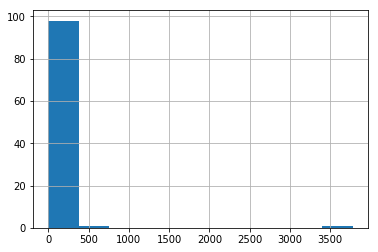

In [101]:
word_clusters = pd.DataFrame(vars(close_words))
word_clusters.groupby('cluster').size().hist()

In [56]:
from collections import Counter
word_frequencies = Counter(word for doc in df_full.tokenized for word in doc.split())

word_frequencies = pd.DataFrame(word_frequencies.most_common(), columns='vocab count'.split())

In [57]:
word_frequencies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108466 entries, 0 to 108465
Data columns (total 2 columns):
vocab    108466 non-null object
count    108466 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.7+ MB


In [102]:
word_clusters = pd.merge(word_clusters, word_frequencies, on='vocab')

In [104]:
import wordfreq

In [105]:
word_clusters['wordfreq'] = [wordfreq.zipf_frequency(term, 'en') for term in word_clusters.vocab]

In [106]:
word_clusters = word_clusters.sort_values('wordfreq', ascending=False)

In [107]:
for i in range(word_kmeans.n_clusters):
    words = word_clusters.vocab[word_clusters.cluster == i]
    #.sample(n=min(len(words), 10))
    print(f"{len(words):3d} {' '.join(words.iloc[:10])}")

 62 little children small young girl child baby boy kids girls
 68 school course class education study students learn training science studies
 21 wet smooth layer mud layers dense texture sticky slick moist
3743 50 73 92 18 65 08 88 96 26 13
 70 easy difficult interesting impossible prevent trouble useful attractive exciting complicated
 54 lot various multiple variety lots thousands numerous thousand crowd massive
106 love thanks thank hate respect enjoy welcome loved agree accept
 67 people city guys community town cool style culture modern district
 32 food eat dinner lunch breakfast meal foods menu delicious meals
 63 think really actually maybe probably gonna guess damn knows unless
 95 dog animals animal wild horse cat farm bear dogs bird
 85 music song performance rock album dance band records soul pop
 69 heard phone hear sound voice listen sounds calls hearing bell
 69 white black light red blue green dark sun color sky
 73 best better greater worst worse largest biggest larg

In [108]:
word_substitute = {}
for i in range(word_kmeans.n_clusters):
    words = word_clusters.vocab[word_clusters.cluster == i]
    ref_word = words.iloc[0].upper()
    for word in words:
        word_substitute[word] = ref_word
len(word_substitute)

10920

In [109]:
print(' '.join(word_clusters.sort_values('wordfreq').vocab.iloc[-500:]))

education comes short red stay son data living report watch happy reason child gonna low woman wanted police special action father age light future development major north community started morning york minutes heart leave idea pretty probably win fuck playing needs turn according hit soon million months past example john saying research understand post ask form university pay saw remember cause late office political 18th matter ago 15th 40th 70th 30th 25th 12th 27th question coming 50th 11th guy 96th wait 28th 24th 20th 10th 14th room close 29th 17th 13th act taken 36th single 38th 45th 19th girl taking wrong nice class yeah friend members court season lost video possible story history hours south body hope guys air health hand book large human talk known president news friends maybe control games half problem true local level car food death information able makes trying service shit fact american mind black actually kind face means says given job early working united young social cou

In [110]:
word_substitute['report']

'50'

In [117]:
def collapse(tokenized):
    result = []
    prev = None
    for token in tokenized.split():
        new_tok = word_substitute.get(token, token)
        if new_tok != prev:
            result.append(new_tok)
            prev = new_tok
    return ' '.join(result)
collapse(sentences_df.sent.iloc[500])

'my FATHER and i 50 this 50 often and have SAID everything from the CHEESE to the FOOD DEAL .'

In [118]:
sentences_df.sent.iloc[500]

'my wife and i frequent this place often and have ordered everything from the burger to the breakfast items .'

In [127]:
word_substitute['service'], word_substitute['staff'], word_substitute['waiter']

('50', 'WORK', 'SERVER')

In [124]:
sents = sentences_df.sent.sample(100, random_state=0)
sents = sents.to_frame('sentence')
sents['collapsed'] = sents.sentence.apply(collapse)
sents

,sentence,collapsed
429541,it had a soupy texture and didn't add anything...,it had a soupy WET and didn't LIKE anything to...
1360208,"friendliness was the not the point , but the f...","friendliness was the not the 50 , but the FOOD..."
1479184,"like i kind of already said , maybe not a lot ...","LIKE i 50 of already SAID , THINK not a LOT fo..."
944131,"when i was in college at cmu , larry & carol's...","when i was in UNIVERSITY at 50 , MR & carol's ..."
57357,"once , my dessert order got lost & i had to ke...","once , my CAKE 50 SAID AWAY & i had to keep WA..."
236345,i enjoyed that it was a very relaxing diner at...,i LOVE that it was a very REST BAR 50 where th...
908294,service was not so great .,50 was not so GREAT .
928169,a patron inside was singled out for being gay ...,a patron 50 was singled out for being 50 and w...
728019,that was the case when we went - and it wasn't...,that was the 50 when we SAID - and it wasn't a...
1186119,great vegan cafe that can wow any meaty lover ...,GREAT VEGETARIAN BAR that can YES any meaty FR...


# Back on main line

For each topic, how many different docs does it occur in?

In [33]:
%matplotlib inline

In [34]:
import seaborn as sns

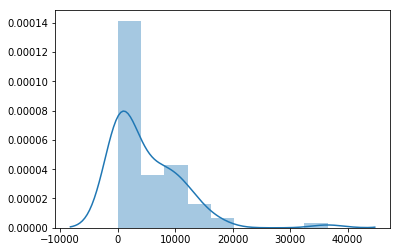

In [35]:
pervasiveness_by_topic = distance_filtered.sentences[['doc_id','topic']].drop_duplicates().groupby('topic').size()
sns.distplot(pervasiveness_by_topic)

TODO: Filter to include only topics that occur in more than 1% of documents.

In [36]:
(pervasiveness_by_topic / len(df_full)).describe()

count    75.000000
mean      0.027911
std       0.034660
min       0.000006
25%       0.000310
50%       0.016171
75%       0.049277
max       0.206053
dtype: float64

In [37]:
min_pervasiveness = .01 * len(df_full)
(pervasiveness_by_topic >= min_pervasiveness).sum()

43

Interpret each topic with a word.

In [38]:
from sklearn.naive_bayes import BernoulliNB
word_to_cluster_clf = BernoulliNB().fit(distance_filtered.raw_vecs, distance_filtered.sentences.topic)


In [39]:
word_to_cluster_clf.coef_.shape

(75, 21912)

In [40]:
label_words = [vocab[idx] for idx in np.argmax(word_to_cluster_clf.coef_, axis=1)]

In [41]:
print('\n'.join(label_words))

taste
early
changing
paninis
make
food
tasty
chicken
beer
playlist
night
avocado
ambiance
good
love
waitress
repeat
didn
place
food
shrimp
classic
sauce
place
wasn
burger
try
crowded
lunch
flavorful
overpriced
place
vegetarian
chicken
crowds
chocolate
cheese
hasn
incident
fresh
tables
selection
ll
fries
food
worth
polite
dishes
mins
stars
pasta
food
friendly
nice
wait
masala
menu
don
thai
bloody
birthday
smelly
comparing
years
deal
portions
forth
ve
chicken
night
la
bad
yam
college
artichoke


In [42]:
import matplotlib.pyplot as plt

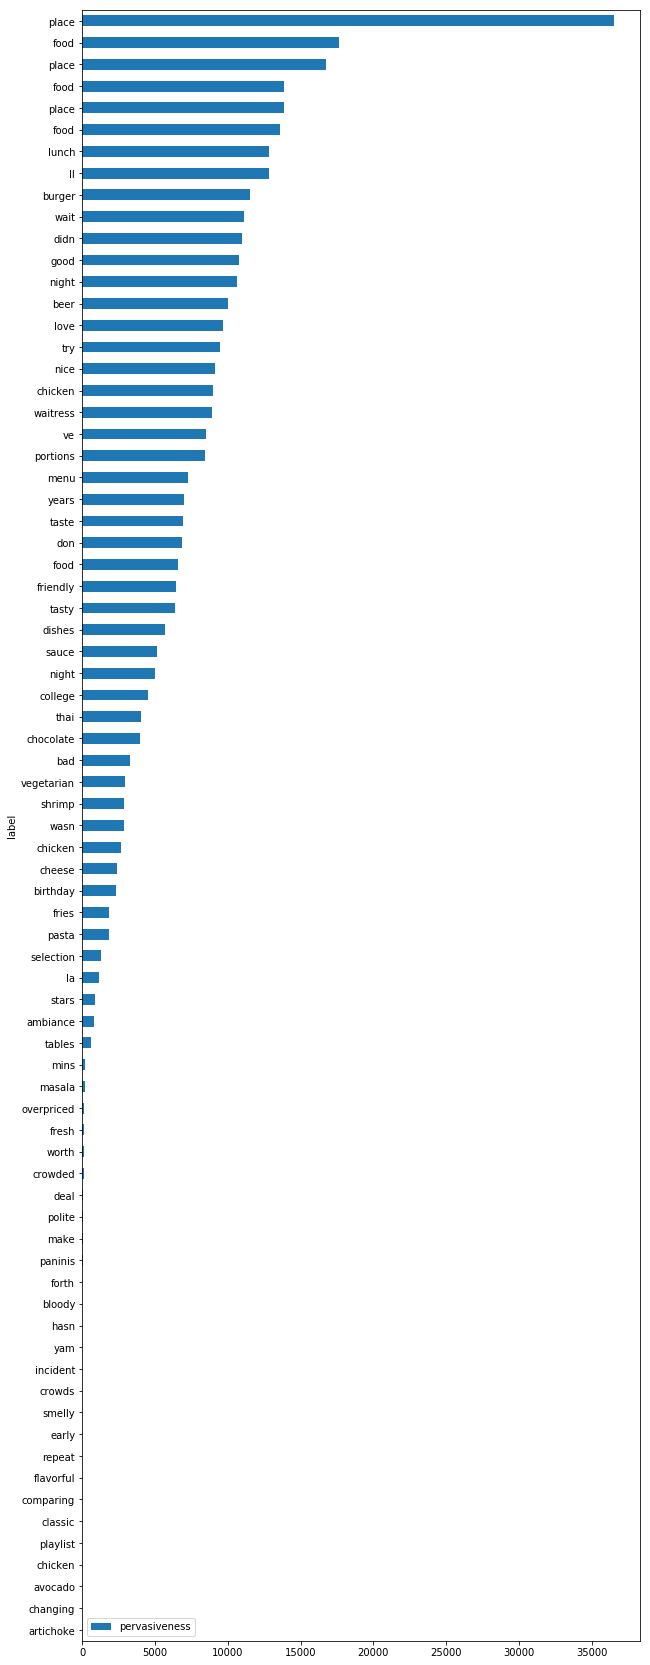

In [43]:
labeled_pervasiveness=pd.DataFrame(dict(pervasiveness=pervasiveness_by_topic, label=label_words))
labeled_pervasiveness.sort_values('pervasiveness', inplace=True)

fig, ax = plt.subplots(figsize=(10, 30))
labeled_pervasiveness.set_index('label').plot.barh(ax=ax)

In [68]:
pervasiveness_by_topic

topic
0      6958
1         4
2         1
3        25
4        51
5     13883
6      6392
7      2649
8      9997
9         2
10    10644
11        1
12      782
13    10779
14     9696
15     8932
16        3
17    10953
18    16724
19    13585
20     2901
21        2
22     5131
23    36507
24     2865
25    11545
26     9494
27      114
28    12826
29        3
      ...  
45      128
46       59
47     5722
48      211
49      876
50     1844
51    17669
52     6432
53     9102
54    11134
55      209
56     7301
57     6850
58     4024
59       16
60     2295
61        4
62        3
63     6968
64       66
65     8410
66       18
67     8529
68        2
69     4983
70     1173
71     3269
72       12
73     4553
74        1
Length: 75, dtype: int64

In [70]:
distance_filtered.sentences = pd.merge(
    distance_filtered.sentences,
    pervasiveness_by_topic.to_frame('pervasiveness'),
    left_on='topic', right_index=True)

In [73]:
with_n_topics = pd.merge(
    df_full,
    distance_filtered.sentences[['doc_id','topic']].drop_duplicates().groupby('doc_id').size().to_frame('n_topics'),
    left_on='review_id', right_index=True
)
with_n_topics = pd.merge(
    with_n_topics,
    distance_filtered.sentences.groupby('doc_id').pervasiveness.min().to_frame('min_pervasiveness'),
    left_on='review_id', right_index=True)

In [74]:
with_n_topics['num_words'] = [len(tok.split()) for tok in with_n_topics.tokenized]

In [75]:
with_n_topics['num_sentences'] = [len(tok.split('\n')) for tok in with_n_topics.tokenized]
with_n_topics['num_chars'] = with_n_topics.text.str.len()

In [76]:
with_n_topics['topic_diversity'] = with_n_topics['n_topics'] / with_n_topics['num_sentences']

In [77]:
with_n_topics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143735 entries, 0 to 177172
Data columns (total 34 columns):
business_id          143735 non-null object
date                 143735 non-null datetime64[ns]
review_id            143735 non-null object
stars_review         143735 non-null int64
text                 143735 non-null object
user_id              143735 non-null object
votes_cool           143735 non-null int64
votes_funny          143735 non-null int64
votes_useful         143735 non-null int64
categories           143735 non-null object
city                 143735 non-null object
latitude             143735 non-null float64
longitude            143735 non-null float64
name                 143735 non-null object
neighborhoods        143735 non-null object
review_count         143735 non-null int64
stars_biz            143735 non-null float64
state                143735 non-null object
average_stars        143735 non-null float64
review_count_user    143735 non-null int64
vot

In [78]:
with_n_topics['is_best'] = with_n_topics['is_best'].astype(int)

In [79]:
import statsmodels.formula.api as smf

is_best
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: num_words, dtype: object

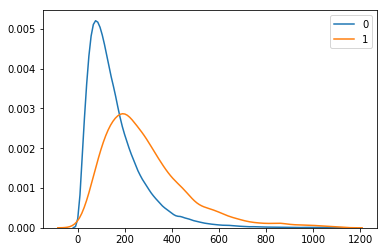

In [60]:
with_n_topics.groupby('is_best').num_words.apply(sns.kdeplot)

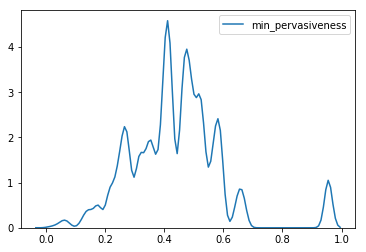

In [86]:
sns.kdeplot(np.sqrt(with_n_topics.min_pervasiveness) / 200)

is_best
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: min_pervasiveness, dtype: object

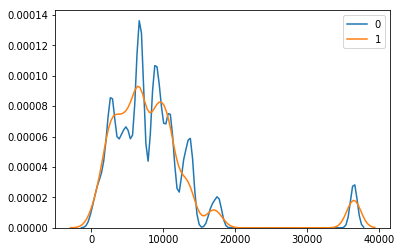

In [80]:
with_n_topics.groupby('is_best').min_pervasiveness.apply(sns.kdeplot)

In [61]:
smf.logit(
    'is_best ~ review_count + stars_biz + age_months + num_sentences + num_words',
    data=with_n_topics).fit().summary()

Optimization terminated successfully.
         Current function value: 0.089041
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                is_best   No. Observations:               143735
Model:                          Logit   Df Residuals:                   143729
Method:                           MLE   Df Model:                            5
Date:                Fri, 15 Mar 2019   Pseudo R-squ.:                 0.09906
Time:                        10:59:27   Log-Likelihood:                -12798.
converged:                       True   LL-Null:                       -14206.
                                        LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -6.0325      0.147    -40.909      0.000      -6.322      -5.743
review_count     -0.0018      0.000    -15.723      0.000      -0.002      -0.002
stars_biz         0.1985      0.039      5.082      0.000       0.122       0.275
age_months        0.0248      0.001     26.628      0.000       0.023       0.027
num_sentences     0.0388      0.004      9.120      0.000       0.030       0.047
num_words         0.0027      0.000     11.060      0.000       0.002       0.003
=================================================================================
"""

In [81]:
smf.logit(
    'is_best ~ review_count + stars_biz + age_months + num_words + num_sentences * n_topics',
    data=with_n_topics).fit().summary()

Optimization terminated successfully.
         Current function value: 0.087623
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                is_best   No. Observations:               143735
Model:                          Logit   Df Residuals:                   143727
Method:                           MLE   Df Model:                            7
Date:                Fri, 15 Mar 2019   Pseudo R-squ.:                  0.1134
Time:                        11:09:46   Log-Likelihood:                -12595.
converged:                       True   LL-Null:                       -14206.
                                        LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -6.4732      0.158    -40.970      0.000      -6.783      -6.163
review_count              -0.0018      0.000    -15.748      0.000      -0.002      -0.002
stars_biz                  0.1892      0.039      4.831      0.000       0.112       0.266
age_months                 0.0245      0.001     26.100      0.000       0.023       0.026
num_words                  0.0017      0.000      7.038      0.000       0.001       0.002
num_sentences              0.1209      0.006     20.750      0.000       0.110       0.132
n_topics                   0.0254      0.019      1.313      0.189      -0.013       0.063
num_sentences:n_topics    -0.0093      0.001    -13.103      0.000      -0.011      -0.008
==========================================================================================
"""

In [87]:
smf.logit(
    'is_best ~ review_count + stars_biz + age_months + num_words + num_sentences + np.sqrt(min_pervasiveness)',
    data=with_n_topics).fit().summary()

Optimization terminated successfully.
         Current function value: 0.088743
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                is_best   No. Observations:               143735
Model:                          Logit   Df Residuals:                   143728
Method:                           MLE   Df Model:                            6
Date:                Fri, 15 Mar 2019   Pseudo R-squ.:                  0.1021
Time:                        11:11:28   Log-Likelihood:                -12755.
converged:                       True   LL-Null:                       -14206.
                                        LLR p-value:                     0.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -6.5944      0.159    -41.389      0.000      -6.907      -6.282
review_count                  -0.0018      0.000    -15.551      0.000      -0.002      -0.002
stars_biz                      0.1964      0.039      5.040      0.000       0.120       0.273
age_months                     0.0244      0.001     26.179      0.000       0.023       0.026
num_words                      0.0025      0.000     10.645      0.000       0.002       0.003
num_sentences                  0.0454      0.004     10.548      0.000       0.037       0.054
np.sqrt(min_pervasiveness)     0.0059      0.001      9.504      0.000       0.005       0.007
==============================================================================================
"""

is_best
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: num_sentences, dtype: object

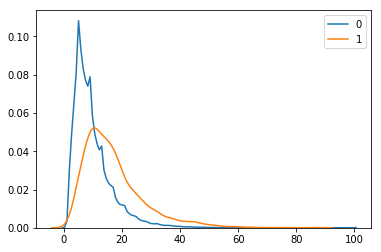

In [88]:
with_n_topics.groupby('is_best').num_sentences.apply(sns.kdeplot)

In [89]:
with_n_topics.groupby('is_best').num_sentences.mean()

is_best
0     9.842840
1    16.975895
Name: num_sentences, dtype: float64

In [91]:
with_n_topics.groupby(['is_best', 'num_sentences']).size().unstack()

num_sentences,1,2,3,4,5,6,7,8,9,10,...,75,76,77,78,79,80,86,87,97,99
is_best,,,,,,,,,,,,,,,,,,,,,
0,1155.0,4249.0,8559.0,11752.0,13497.0,13123.0,12163.0,10830.0,9545.0,8272.0,...,3.0,2.0,1.0,2.0,1.0,1.0,NaN,NaN,1.0,1.0
1,3.0,10.0,29.0,53.0,82.0,110.0,102.0,140.0,169.0,159.0,...,NaN,NaN,1.0,NaN,1.0,NaN,1.0,1.0,NaN,NaN


Let's look at 5-sentence reviews.

In [108]:
for row in (
    with_n_topics[with_n_topics.num_sentences==5]
    .groupby('is_best')
    .text.apply(lambda x: x.sample(n=10, random_state=10))).reset_index().sample(frac=1).itertuples():
#    print(is_best, text.replace('\n', ' '))
    print(row.text.replace('\n', ' '))
#     print(row.is_best)
    print()

Casual sophistication, with really good food.  We went with about 10 of us, and everyone liked what they got.  That's a pretty good batting average.  Asian fusion with a focus on Thai and Vietnamese.   This isn't a fancy place, but it's well done, and worth a trip.

The mozzarella and tomato salad was fresh but small. I also had their lobster risotto and it was perfect. Large chunks of well cooked lobster, oh my! Dessert didn't seem to be their specialty - their selection of teas and sweets was pretty slim. They do have a nice al fresco dining area, perfect for those warm Boston summer nights.

One of my favorite places. My husband and I often hang out at the cozy little bar which is even more cozy in the winter with the little open fireplace. They have great food and wonderful service. The deck in the summer is nice too. The whole place has such a delightful, romantic atomsphere.

Solid place, and none of the pizzas I've tried have disappointed (steak and gorgonzola, and anything with

In [133]:
with_n_topics['sqrt_votes_useful'] = np.sqrt(with_n_topics.votes_useful)

In [142]:
with_n_topics.sqrt_votes_useful = np.minimum(with_n_topics.sqrt_votes_useful, 2)

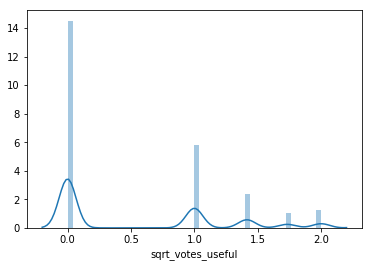

In [143]:
sns.distplot(with_n_topics.sqrt_votes_useful)

In [147]:
smf.ols('sqrt_votes_useful ~ review_count + stars_biz + age_months + num_sentences + num_chars', data=with_n_topics).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      sqrt_votes_useful   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     4575.
Date:                Wed, 13 Mar 2019   Prob (F-statistic):               0.00
Time:                        17:04:03   Log-Likelihood:            -1.3478e+05
No. Observations:              141591   AIC:                         2.696e+05
Df Residuals:                  141585   BIC:                         2.696e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.1349      0.013    -10.509      0.000      -0.160      -0.110
review_count     -0.0002    7.6e-06    -24.617      0.000      -0.000      -0.000
stars_biz         0.0652      0.003     18.812      0.000       0.058       0.072
age_months        0.0082   8.77e-05     93.285      0.000       0.008       0.008
num_sentences     0.0083      0.001     14.826      0.000       0.007       0.009
num_chars         0.0002   6.56e-06     36.935      0.000       0.000       0.000
==============================================================================
Omnibus:                    13843.477   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9950.159
Skew:                           0.545   Prob(JB):                         0.00
Kurtosis:                       2.295   Cond. No.                     7.93e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.93e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [150]:
smf.ols('sqrt_votes_useful ~ review_count + stars_biz + age_months + num_sentences + num_chars + n_topics + n_topics^2', data=with_n_topics).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      sqrt_votes_useful   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     3314.
Date:                Wed, 13 Mar 2019   Prob (F-statistic):               0.00
Time:                        17:06:06   Log-Likelihood:            -1.3464e+05
No. Observations:              141591   AIC:                         2.693e+05
Df Residuals:                  141583   BIC:                         2.694e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.1165      0.013     -9.052      0.000      -0.142      -0.091
review_count     -0.0002   7.59e-06    -24.645      0.000      -0.000      -0.000
stars_biz         0.0664      0.003     19.181      0.000       0.060       0.073
age_months        0.0081   8.78e-05     92.206      0.000       0.008       0.008
num_sentences     0.0125      0.001     20.345      0.000       0.011       0.014
num_chars         0.0002   6.59e-06     35.252      0.000       0.000       0.000
n_topics         -0.0178      0.001    -12.597      0.000      -0.021      -0.015
n_topics ^ 2     -0.0032      0.001     -3.780      0.000      -0.005      -0.002
==============================================================================
Omnibus:                    13712.408   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9878.699
Skew:                           0.543   Prob(JB):                         0.00
Kurtosis:                       2.297   Cond. No.                     7.96e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.96e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [151]:
smf.ols('sqrt_votes_useful ~ review_count + stars_biz + age_months + num_sentences + num_chars + C(n_topics)', data=with_n_topics).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      sqrt_votes_useful   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     1018.
Date:                Wed, 13 Mar 2019   Prob (F-statistic):               0.00
Time:                        17:07:40   Log-Likelihood:            -1.3455e+05
No. Observations:              141591   AIC:                         2.691e+05
Df Residuals:                  141567   BIC:                         2.694e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.1594      0.013    -12.271      0.000      -0.185      -0.134
C(n_topics)[T.2]      0.0010      0.004      0.224      0.822      -0.008       0.010
C(n_topics)[T.3]     -0.0132      0.005     -2.580      0.010      -0.023      -0.003
C(n_topics)[T.4]     -0.0290      0.006     -4.574      0.000      -0.041      -0.017
C(n_topics)[T.5]     -0.0384      0.008     -4.748      0.000      -0.054      -0.023
C(n_topics)[T.6]     -0.0968      0.011     -9.107      0.000      -0.118      -0.076
C(n_topics)[T.7]     -0.0933      0.014     -6.829      0.000      -0.120      -0.067
C(n_topics)[T.8]     -0.1680      0.018     -9.484      0.000      -0.203      -0.133
C(n_topics)[T.9]     -0.2844      0.024    -11.938      0.000      -0.331      -0.238
C(n_topics)[T.10]    -0.3272      0.032    -10.107      0.000      -0.391      -0.264
C(n_topics)[T.11]    -0.3860      0.043     -8.996      0.000      -0.470      -0.302
C(n_topics)[T.12]    -0.4151      0.057     -7.237      0.000      -0.528      -0.303
C(n_topics)[T.13]    -0.4663      0.085     -5.481      0.000      -0.633      -0.300
C(n_topics)[T.14]    -0.3602      0.121     -2.973      0.003      -0.598      -0.123
C(n_topics)[T.15]    -0.6248      0.157     -3.978      0.000      -0.933      -0.317
C(n_topics)[T.16]    -0.7462      0.189     -3.940      0.000      -1.117      -0.375
C(n_topics)[T.17]    -1.1384      0.313     -3.635      0.000      -1.752      -0.525
C(n_topics)[T.18]    -0.8626      0.626     -1.377      0.168      -2.090       0.365
C(n_topics)[T.19]    -1.3462      0.443     -3.040      0.002      -2.214      -0.478
review_count         -0.0002   7.59e-06    -24.706      0.000      -0.000      -0.000
stars_biz             0.0669      0.003     19.347      0.000       0.060       0.074
age_months            0.0081   8.77e-05     92.392      0.000       0.008       0.008
num_sentences         0.0130      0.001     21.159      0.000       0.012       0.014
num_chars             0.0002   6.59e-06     34.935      0.000       0.000       0.000
==============================================================================
Omnibus:                    13766.961   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9861.707
Skew:                           0.542   Prob(JB):                         0.00
Kurtosis:                       2.295   Cond. No.                     3.75e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.75e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [152]:
smf.ols('sqrt_votes_useful ~ review_count + stars_biz + age_months + num_chars + num_sentences *n_topics', data=with_n_topics).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      sqrt_votes_useful   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     3422.
Date:                Wed, 13 Mar 2019   Prob (F-statistic):               0.00
Time:                        17:08:44   Log-Likelihood:            -1.3432e+05
No. Observations:              141591   AIC:                         2.687e+05
Df Residuals:                  141583   BIC:                         2.687e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.2147      0.013    -16.047      0.000      -0.241      -0.188
review_count              -0.0002   7.57e-06    -24.968      0.000      -0.000      -0.000
stars_biz                  0.0680      0.003     19.672      0.000       0.061       0.075
age_months                 0.0081   8.76e-05     92.536      0.000       0.008       0.008
num_chars                  0.0002   6.58e-06     33.667      0.000       0.000       0.000
num_sentences              0.0214      0.001     30.380      0.000       0.020       0.023
n_topics                   0.0102      0.002      5.956      0.000       0.007       0.014
num_sentences:n_topics    -0.0020   7.89e-05    -25.692      0.000      -0.002      -0.002
==============================================================================
Omnibus:                    13940.682   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9746.001
Skew:                           0.535   Prob(JB):                         0.00
Kurtosis:                       2.286   Cond. No.                     8.27e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.27e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [154]:
smf.ols('sqrt_votes_useful ~ review_count + stars_biz + age_months + num_chars + num_sentences + topic_diversity', data=with_n_topics).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      sqrt_votes_useful   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     3921.
Date:                Wed, 13 Mar 2019   Prob (F-statistic):               0.00
Time:                        17:11:43   Log-Likelihood:            -1.3450e+05
No. Observations:              141591   AIC:                         2.690e+05
Df Residuals:                  141584   BIC:                         2.691e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.0389      0.013     -2.895      0.004      -0.065      -0.013
review_count       -0.0002   7.58e-06    -24.764      0.000      -0.000      -0.000
stars_biz           0.0667      0.003     19.286      0.000       0.060       0.073
age_months          0.0081   8.77e-05     91.844      0.000       0.008       0.008
num_chars           0.0002   6.58e-06     34.771      0.000       0.000       0.000
num_sentences       0.0071      0.001     12.635      0.000       0.006       0.008
topic_diversity    -0.2470      0.010    -23.711      0.000      -0.267      -0.227
==============================================================================
Omnibus:                    14326.412   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9849.389
Skew:                           0.535   Prob(JB):                         0.00
Kurtosis:                       2.277   Cond. No.                     8.63e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [157]:
with_n_topics.drop(columns='business_id date review_id text user_id categories city name neighborhoods tokenized'.split()).to_csv('with_n_topics.csv')

In [158]:
!open .

In [ ]:
def show_cluster(idx):
    close_indices = np.argsort(dists_to_centers[:,idx])[:10]
    for idx in close_indices:
        print(sents_2[idx][:100])
for i in range(dists_to_centers.shape[1]):
    print()
    print(i)
    close_indices = np.argsort(dists_to_centers[:,i])[:10]
    for idx in close_indices:
        print(sents_2[idx])
#    orig_docs = doc_idx_0[orig_indices_2[close_indices]]
#    orig_stars = reviews.stars_review.iloc[orig_docs]
#    print(np.bincount(orig_stars, minlength=5)[1:])
#    all_stars.append(orig_stars)


Represent a document as a sequence of topics.

In [133]:
def label_topics(tokenized_doc):
    sents = tokenized_doc.split('\n')
    vecs = vectorizer.transform(sents)
    projected = vecs.dot(projection_mat)
    clusters = mbk_wordvecs.predict(projected)
    return ' '.join(str(cluster) for cluster in clusters)
label_topics(df_full.tokenized.iloc[5])

'50 13 68 68 46'

In [134]:
print(df_full.tokenized.iloc[5])

we celebrated our anniversary at the lawrence last night and it was all wonderful : potted shrimp , rabbit rillettes , littleneck clams , pork cheeks w / pappardelle and the tri - tip followed by some sort of chocolate / caramel / pretzel deliciousness .
the fried green tomato amuse bouche was a nice touch !
we also went for drinks a few weeks ago and it was a fun , lively spot on a saturday night , no doubt fueled by eric's delicious cocktails .
i am so happy to have a spot in the neighborhood where i can stop in for a drink and a snack or celebrate with a complete , upscale dining experience .
we drove and it was no problem to find free street parking on juniper .


In [135]:
import tqdm

In [136]:
df_full['topic_seq'] = [label_topics(tokenized) for tokenized in tqdm.tqdm_notebook(df_full.tokenized)]

In [137]:
from textrec.paths import paths

In [138]:
with open(paths.models / "topic_sequence.txt", 'w') as f:
    for line in df_full.topic_seq:
        f.write(line + '\n')

In [140]:
from textrec.util import dump_kenlm

In [141]:
dump_kenlm('topic_sequence', df_full.topic_seq)

In [142]:
from textrec.lang_model import Model

In [144]:
model = Model.get_or_load_model('topic_sequence')

Loading model topic_sequence ... reading raw ARPA data ...  Encoding bigrams to indices... Loaded.


In [146]:
model.score_seq(model.bos_state, '50 13 68 68 46 </s>')

(-137.79803202770034, State([], []))

In [150]:
def topic_sequence_perplexity(topic_seq):
    logprob, state = model.score_seq(model.bos_state, topic_seq + " </s>")
    return -logprob

In [151]:
df_full['topic_seq_perplexity'] = [topic_sequence_perplexity(seq) for seq in tqdm.tqdm_notebook(df_full.topic_seq)]

In [158]:
import matplotlib.pyplot as plt
import seaborn as sns

is_best
False    AxesSubplot(0.125,0.125;0.775x0.755)
True     AxesSubplot(0.125,0.125;0.775x0.755)
Name: topic_seq_perplexity, dtype: object

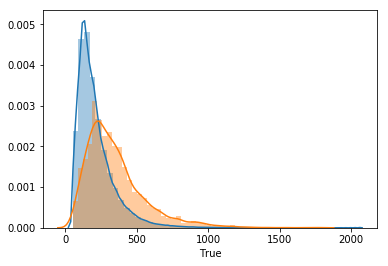

In [160]:
df_full.groupby('is_best').topic_seq_perplexity.apply(sns.distplot)


In [161]:
df_full.groupby('is_best').topic_seq_perplexity.mean()

is_best
False    210.546438
True     348.401128
Name: topic_seq_perplexity, dtype: float64